**Projet analyse de tweets Real or Fake**

In [ ]:
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import string
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
tf.__version__

'2.2.0'

In [ ]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")
df_submission =  pd.read_csv("/content/sample_submission.csv")

In [ ]:
df_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_train.shape

(7613, 5)

In [ ]:
df_test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
df_submission.head(5)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


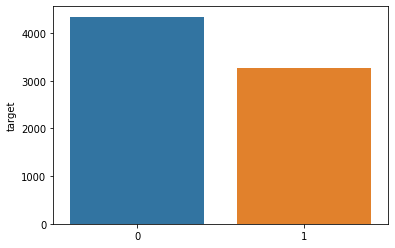

In [ ]:
target = df_train['target'].value_counts()
sns.barplot(x = target.index, y = target)

**Notre dataset est plutôt bien équilibré**

In [ ]:
df_train.isnull().sum().sort_values(ascending = False)

location    2533
keyword       61
target         0
text           0
id             0
dtype: int64

**Analyse et comparaison entre Fake / Non Fake**

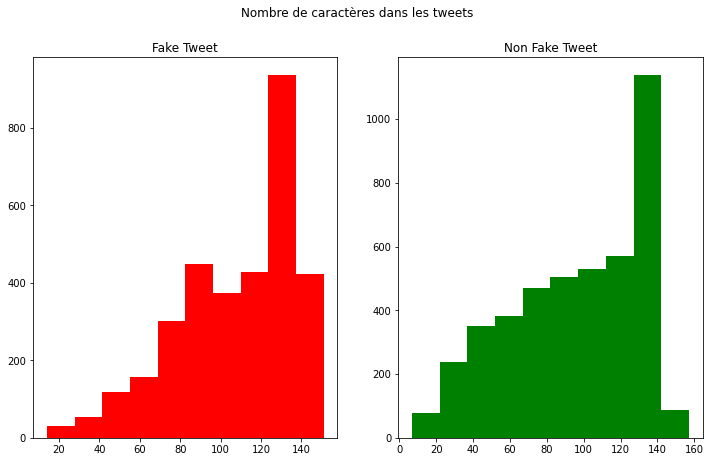

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,7))
tweet_len = df_train[df_train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Fake Tweet')
tweet_len = df_train[df_train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Non Fake Tweet')
fig.suptitle('Nombre de caractères dans les tweets')
plt.show()

**Analyse du texte**

In [ ]:
df_train.keyword.value_counts()[:15]

fatalities     45
deluge         42
armageddon     42
damage         41
harm           41
body%20bags    41
sinking        41
outbreak       40
fear           40
twister        40
siren          40
collided       40
evacuate       40
windstorm      40
collision      39
Name: keyword, dtype: int64

In [ ]:
def Plot_world(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 


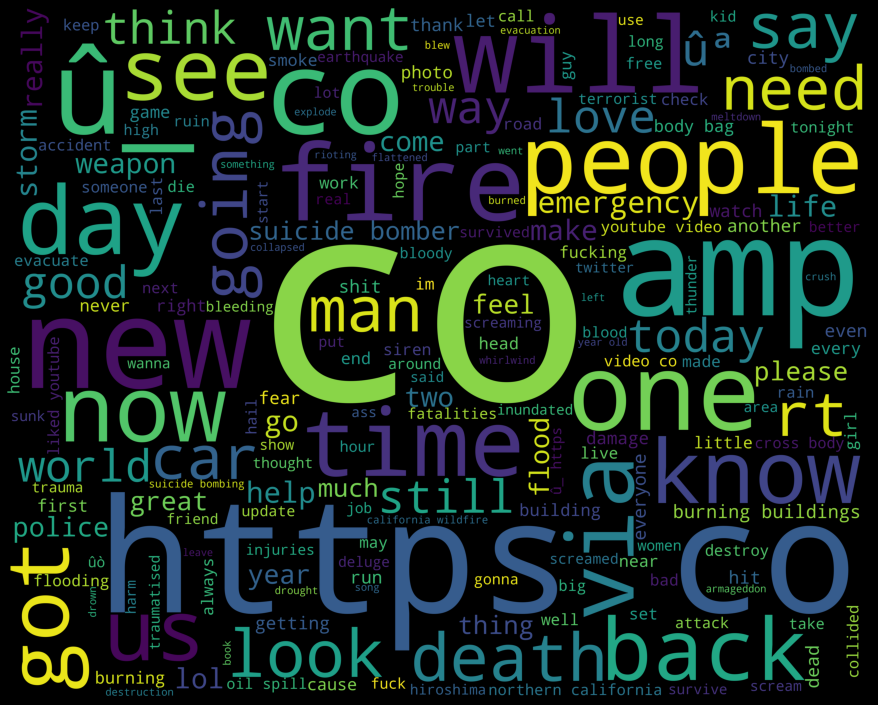

In [ ]:
text = df_train.text.values
Plot_world(text)

**On distingue beaucoup de mots abérants et inutiile à notre analyse, procédons à un nettoyage**

In [ ]:
def supp_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [ ]:
df_train['text'] = df_train['text'].apply(lambda x : supp_URL(x))
df_train.loc[df_train['text'].str.contains('http')].target.value_counts()

0    1
Name: target, dtype: int64

In [ ]:
df_test['text'] = df_test['text'].apply(lambda x : supp_URL(x))

**Remplaçons maintenant toutes les contractions**

In [ ]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"thx"   : "thanks"
}

In [ ]:
def replace_contractions(text):
    return contractions[text.lower()] if text.lower() in contractions.keys() else text

In [ ]:
df_train['text'] = df_train['text'].apply(replace_contractions)
df_test['text'] = df_test['text'].apply(replace_contractions)

**Enfin supprimons la poncuation qui pourrait altérer nos prédictions**

In [ ]:
def supp_ponct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

In [ ]:
df_train['text'] = df_train['text'].apply(lambda x : supp_ponct(x))
df_test['text'] = df_test['text'].apply(lambda x : supp_ponct(x))

In [ ]:
df_train['text'][42]

'Had an awesome time visiting the CFC head office the ancop site and ablaze Thanks to Tita Vida for taking care of us '

**Nous avons désormais des phrases propres**

**Nous utilisons GloVe pour vectoriser nos tweets**

In [ ]:
stop = set(stopwords.words('english'))

def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df_train['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
        
        

In [ ]:
corpus_train = create_corpus(df_train)
corpus_test = create_corpus(df_test)

100%|██████████| 7613/7613 [00:01<00:00, 6481.17it/s]


In [ ]:
embedding_dict = {}

with open('/content/glove.6B.100d.txt','r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
f.close()

In [ ]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus_train)
sequences = tokenizer_obj.texts_to_sequences(corpus_train)

tweet_pad = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
MAX_LEN = 50
tokenizer_obj2 = Tokenizer()
tokenizer_obj2.fit_on_texts(corpus_test)
sequences = tokenizer_obj2.texts_to_sequences(corpus_test)

tweet_pad = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
word_index = tokenizer_obj.word_index
len(word_index)

16230

In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
            

100%|██████████| 16230/16230 [00:00<00:00, 427069.23it/s]


In [ ]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1623100   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,665,405
Trainable params: 42,305
Non-trainable params: 1,623,100
_________________________________________________________________


In [ ]:
train= tweet_pad[:df_train.shape[0]]
test= tweet_pad[df_train.shape[0]:]

In [ ]:
train.shape

(7613, 50)

In [ ]:
test.shape

(0, 50)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(train,df_train['target'].values,test_size=0.15)

print(X_train.shape)
print(X_test.shape)

(6471, 50)
(1142, 50)


In [ ]:
training = model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
 - 35s - loss: 0.6916 - accuracy: 0.5650 - val_loss: 0.6887 - val_accuracy: 0.5884
Epoch 2/15
 - 34s - loss: 0.6831 - accuracy: 0.5698 - val_loss: 0.6496 - val_accuracy: 0.5981
Epoch 3/15
 - 35s - loss: 0.6124 - accuracy: 0.6769 - val_loss: 0.5457 - val_accuracy: 0.7662
Epoch 4/15
 - 35s - loss: 0.5826 - accuracy: 0.7215 - val_loss: 0.5267 - val_accuracy: 0.7732
Epoch 5/15
 - 34s - loss: 0.5694 - accuracy: 0.7342 - val_loss: 0.5187 - val_accuracy: 0.7715
Epoch 6/15
 - 35s - loss: 0.5574 - accuracy: 0.7453 - val_loss: 0.5156 - val_accuracy: 0.7723
Epoch 7/15
 - 35s - loss: 0.5515 - accuracy: 0.7458 - val_loss: 0.5102 - val_accuracy: 0.7750
Epoch 8/15
 - 34s - loss: 0.5518 - accuracy: 0.7430 - val_loss: 0.5120 - val_accuracy: 0.7697
Epoch 9/15
 - 34s - loss: 0.5503 - accuracy: 0.7492 - val_loss: 0.5057 - val_accuracy: 0.7776
Epoch 10/15
 - 35s - loss: 0.5468 - accuracy: 0.7526 - val_loss: 0.5040 - val_accuracy: 0.7750
Epoch 11/15